# Прогнозирование оттока клиентов
___

### Описание задачи
___

Представлены данные компании, предоставляющей услуги связи для населения.

Необходимо подготовить модель, которая будет прогнозировать отток клиентов компании. Если выяснится, что клиент планирует уйти, ему будут предложены промокоды и специальные условия для удержания. 

Cобраны персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Данные

В нашем распоряжении имеются данные по клиентам компании, разделенные на 4 датасета:

 - **`contract`** - информация о договоре;
 
 
 - **`personal`** - персональные данные клиента;
 
 
 - **`internet`** - персональные данные клиента;
 
 
 - **`phone`** - информация об услугах телефонии.

### Признаки

 Датасет **`contract`** содежрит следующие признаки:
 
 - **`customerID`** - код клиента;
 
 
 - **`BeginDate`** - дата заключения договора;
 
 
 - **`EndDate`** - дата окончания договора;
 
 
 - **`Type`** - тип заключаемых договоров;
 
 
 - **`PaperlessBilling`** - 
 
 
 - **`PaymentMethod`** - способ оплаты;
 
 
 - **`MonthlyCharges`** - ежемесячные траты клиента;
 
 
 - **`TotalCharges`** - все затраты клиента.
 
 
 Датасет **`personal`** содежрит следующие признаки:

 - **`customerID`** - код клиента;
 
 
 - **`gender`** - пол клиента;
 
 
 - **`SeniorCitizen`** - пинсионер клиент или нет;
 
 
 - **`Partner`** - имеет ли клиент партнера (одинок он или нет);
 
 
 - **`Dependents`** - имеет ли клиент иждивенцев.
 
 
 Датасет **`internet`** содежрит следующие признаки:
 
 - **`customerID`** - код клиента;


 - **`InternetService`** - способ подключения интернета;
 
 
 - **`OnlineSecurity`** - наличие онлайн защиты;
 
 
 - **`OnlineBackup`** - наличие резервного копирования;
 
 
 - **`DeviceProtection`** - наличие защиты устройства;
 
 
 - **`TechSupport`** - обращение в техническую поддержку;
 
 
 - **`StreamingTV`** - наличие подписки на стриминговый TV;
 
 
 - **`StreamingMovies`** - наличие подписки на сервис стриминга фильмов.
 
 
Датасет **`phone`** содежрит следующие признаки:

- **`customerID`** - код клиента;


- **`MultipleLines`** - наличие нескольких линий.

### План работы
___

1. Загрузка данных
2. Исследование датафреймов
3. Проведение предобработки данных
4. Определение целевого показателя
5. Разделение данных на выборки
6. Обучение различных моделей с определением лучших гиперпараметров
7. Проверка качества лучшей модели на тестовой выборке
8. Анализ лучшей модели (важность признаков, матрица ошибок)

### Загрузка данных
___

In [1]:
!pip install shap

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
sklearn.__version__
import shap

from tqdm import tqdm

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Прочитаем датафреймы и сразу возьмем в качестве индексов общий столбец `customerID`.

In [2]:
data_contract = pd.read_csv('contract_new.csv', index_col='customerID', parse_dates=True)

In [3]:
data_personal = pd.read_csv('personal_new.csv', index_col='customerID')

In [4]:
data_internet = pd.read_csv('internet_new.csv', index_col='customerID')

In [5]:
data_phone = pd.read_csv('phone_new.csv', index_col='customerID')

Выведем общую информацию о представленных данных:

In [6]:
def info(data):
    print('Первые пять строк датасета')
    print(data.head())
    
    print()
    print('Информация')
    print(data.info())
    
    print()
    print('Пропуски')
    print(data.isna().sum())
    
    print()
    print('Статистика')
    print(data.describe(include='all'))

In [7]:
info(data_contract)

Первые пять строк датасета
             BeginDate EndDate            Type PaperlessBilling  \
customerID                                                        
7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
5575-GNVDE  2017-04-01      No        One year               No   
3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
7795-CFOCW  2016-05-01      No        One year               No   
9237-HQITU  2019-09-01      No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  
customerID                                                          
7590-VHVEG           Electronic check           29.85        31.04  
5575-GNVDE               Mailed check           56.95      2071.84  
3668-QPYBK               Mailed check           53.85       226.17  
7795-CFOCW  Bank transfer (automatic)           42.30       1960.6  
9237-HQITU           Electronic check           70.70        353.5  

Информация
<class '

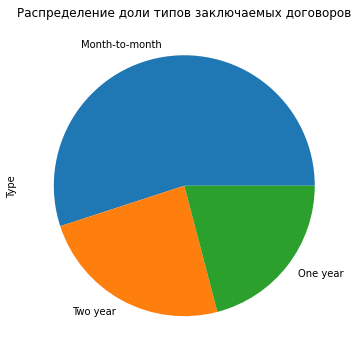

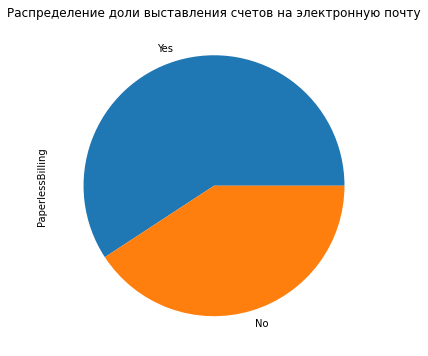

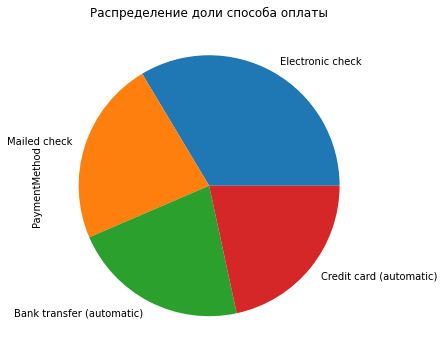

In [8]:
data_contract['Type'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли типов заключаемых договоров')
plt.show()

data_contract['PaperlessBilling'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли выставления счетов на электронную почту')
plt.show()

data_contract['PaymentMethod'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли способа оплаты')
plt.show()

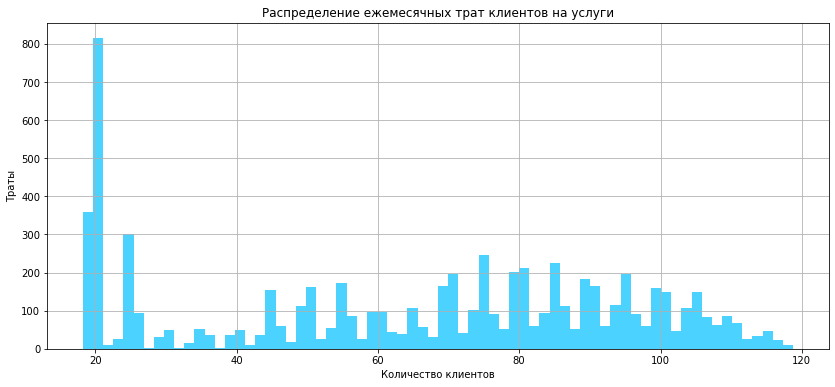

In [9]:
data_contract.hist(figsize=(14, 6), bins=70, alpha=0.7, color='deepskyblue')
plt.title('Распределение ежемесячных трат клиентов на услуги')
plt.ylabel('Траты')
plt.xlabel('Количество клиентов')
plt.show()

In [10]:
info(data_personal)

Первые пять строк датасета
            gender  SeniorCitizen Partner Dependents
customerID                                          
7590-VHVEG  Female              0     Yes         No
5575-GNVDE    Male              0      No         No
3668-QPYBK    Male              0      No         No
7795-CFOCW    Male              0      No         No
9237-HQITU  Female              0      No         No

Информация
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None

Пропуски
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Статистика
       gender  SeniorCitizen Partner Dependents


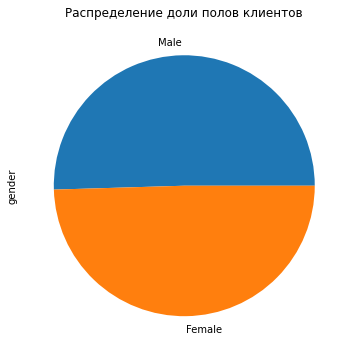

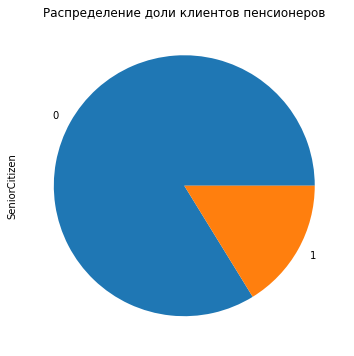

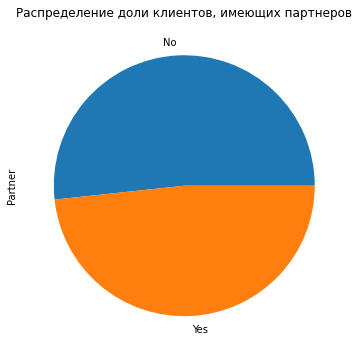

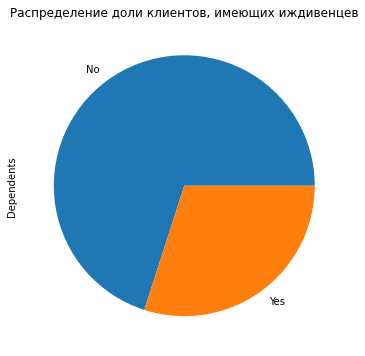

In [11]:
data_personal['gender'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли полов клиентов')
plt.show()

data_personal['SeniorCitizen'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов пенсионеров')
plt.show()

data_personal['Partner'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих партнеров')
plt.show()

data_personal['Dependents'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих иждивенцев')
plt.show()

In [12]:
info(data_internet)

Первые пять строк датасета
           InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
7590-VHVEG             DSL             No          Yes               No   
5575-GNVDE             DSL            Yes           No              Yes   
3668-QPYBK             DSL            Yes          Yes               No   
7795-CFOCW             DSL            Yes           No              Yes   
9237-HQITU     Fiber optic             No           No               No   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
7590-VHVEG          No          No              No  
5575-GNVDE          No          No              No  
3668-QPYBK          No          No              No  
7795-CFOCW         Yes          No              No  
9237-HQITU          No          No              No  

Информация
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-

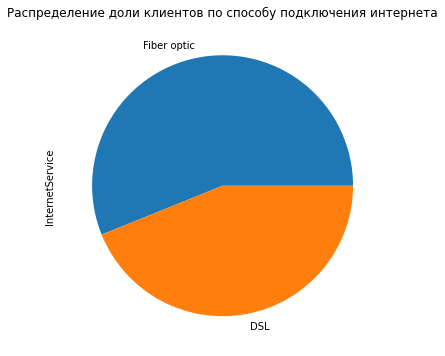

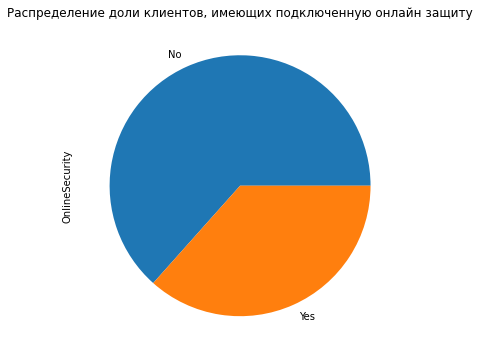

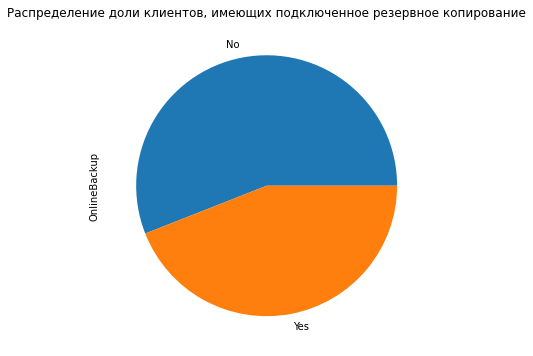

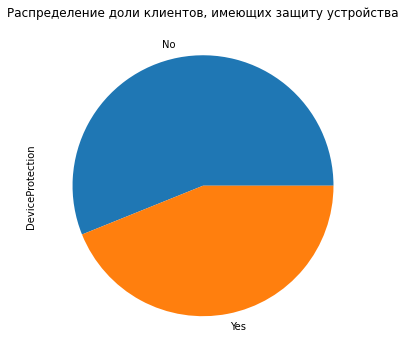

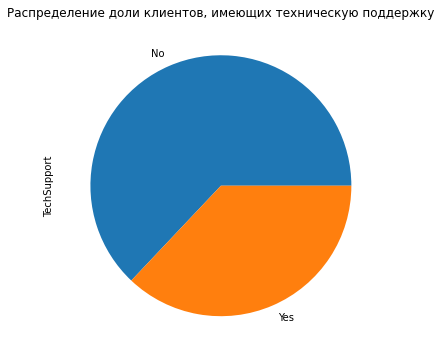

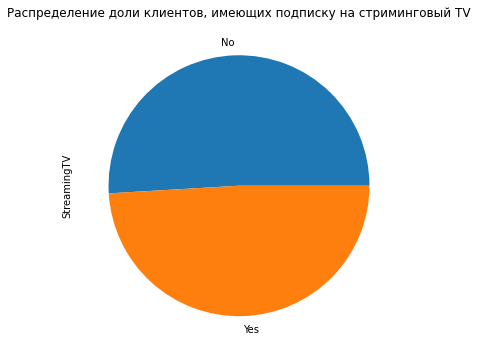

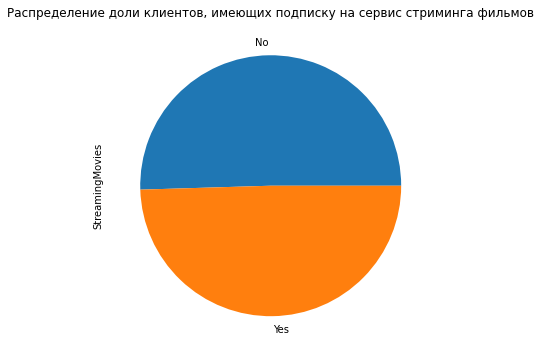

In [13]:
data_internet['InternetService'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов по способу подключения интернета')
plt.show()

data_internet['OnlineSecurity'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих подключенную онлайн защиту')
plt.show()

data_internet['OnlineBackup'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих подключенное резервное копирование')
plt.show()

data_internet['DeviceProtection'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих защиту устройства')
plt.show()

data_internet['TechSupport'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих техническую поддержку')
plt.show()

data_internet['StreamingTV'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих подписку на стриминговый TV')
plt.show()

data_internet['StreamingMovies'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих подписку на сервис стриминга фильмов')
plt.show()

In [14]:
info(data_phone)

Первые пять строк датасета
           MultipleLines
customerID              
5575-GNVDE            No
3668-QPYBK            No
9237-HQITU            No
9305-CDSKC           Yes
1452-KIOVK           Yes

Информация
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None

Пропуски
MultipleLines    0
dtype: int64

Статистика
       MultipleLines
count           6361
unique             2
top               No
freq            3390


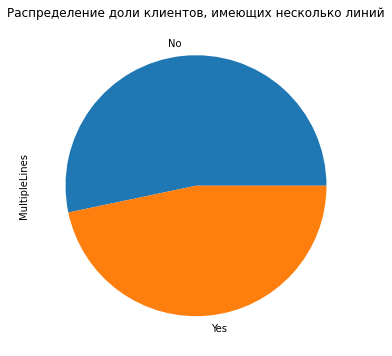

In [15]:
data_phone['MultipleLines'].value_counts().plot.pie(subplots=True, figsize=(6, 6))
plt.title('Распределение доли клиентов, имеющих несколько линий')
plt.show()

Мы загрузили данные, посмотрели, как они выглядят, что содержат и какое имеют распределение данных. Целевым показателем является столбец **`EndDate`**, он и будет нашим таргетом.

Итак, что нам предстоит сделать:

- объединить все датасеты в один;
- провести предобработку (изменить тип данных, заполнить пропуски, изменить значения);
- удалить столбцы, которые не помогут в исследовании данных;
- разделить датасет на обучающую и тестовую выборки;
- проанализировать три различные модели обучения;
- выбрать лучшую и проверить ее качества на тестовой выборке.

### Предобработка данных
___

Приведем названия столбцов датасета `data_contract` к нижнему регистру:

In [16]:
data_contract.columns = data_contract.columns.str.lower()

Уберем пропуски в столбце `totalcharges`:

In [17]:
data_contract['totalcharges'] = data_contract['totalcharges'].replace(r'^\s*S', np.nan, regex=True)

Так как нашей целевой метрикой является факт ухода клиента, то выведем новый признак из столбца `enddate` и назовем его `exited`. Поместим туда бинарные значения, которые отражают `1` - если клиент разорвал контракт и `0` если он по-прежнему клиент организации: 

In [18]:
data_contract['exited'] = data_contract.apply(lambda x: 0 if x.enddate == 'No' else 1, axis=1)

Заполним пропуски в столбце `enddate`. Если клиент не разорвал контракт с организацией, то значение данного столбца остается пустым, для дальнейшего исследования заполнил пустоты датой выгрузки данных, а именно - `2020-02-01`:

In [19]:
data_contract.loc[(data_contract['enddate'] == 'No'), 'enddate'] = '2020-02-01'

Приведем столбцы `begindate` и `enddate` к формату даты:

In [20]:
data_contract['begindate'] = pd.to_datetime(data_contract['begindate'], format='%Y-%m-%d')
data_contract['enddate'] = pd.to_datetime(data_contract['enddate'], format='%Y-%m-%d')

Добавим еще один признак к данным, это продолжительность контракта в днях, назовем столбец `dayscharges`:

In [21]:
data_contract['dayscharges'] = (data_contract['enddate'] - data_contract['begindate']).dt.days

In [22]:
data_contract.head()

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,exited,dayscharges
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


Посмотрим, имеет ли столбец `monthlycharges` выбросы:

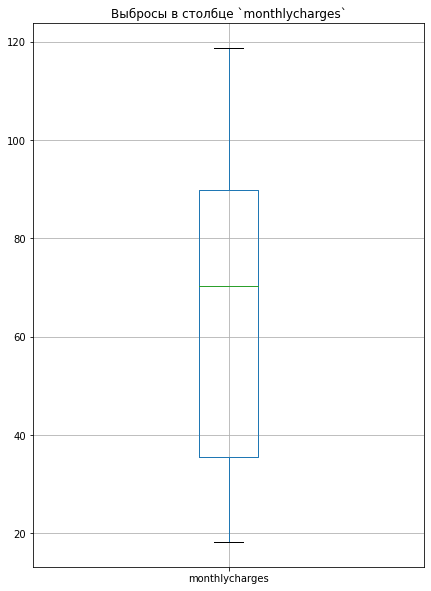

In [23]:
ax=data_contract.boxplot(column = 'monthlycharges', showfliers=False, figsize=(7,10))
plt.title('Выбросы в столбце `monthlycharges`')
plt.show()

Как видим из графика с усами, значения `monthlycharges` выше 118 и ниже 18 являются выбросами данных, уберем их:

In [24]:
data_contract = data_contract.query('monthlycharges <= 118 and monthlycharges >= 18')

Выделим столбец `beginyear`, чтобы посмотреть на распределение данных по годам:

In [25]:
data_contract['beginyear'] = pd.DatetimeIndex(data_contract['begindate']).year

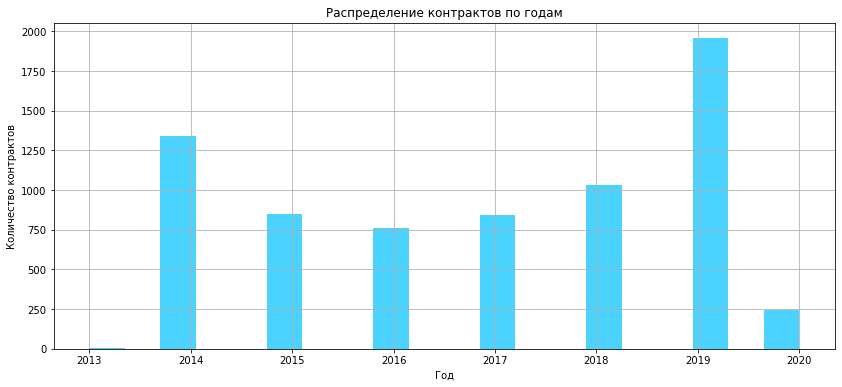

In [26]:
data_contract['beginyear'].hist(figsize=(14, 6), bins=20, alpha=0.7, color='deepskyblue')
plt.title('Распределение контрактов по годам')
plt.ylabel('Количество контрактов')
plt.xlabel('Год')
plt.show()

Как видно из диаграммы, количество заключенных контрактов в 2013 году очень мало и, вероятно, не повлияет на результат, поэтому уберем их, также уберем данные за 2020 год, ведь они хранят данные всего за один полный месяц и не дадут реального результата:

In [27]:
data_contract = data_contract.query('beginyear > 2013 and beginyear < 2020')

Приведем остальные датасеты к нижнему регистру:

In [28]:
def low_column(x):
    x.columns = x.columns.str.lower()
    return x

In [29]:
low_column(data_personal)

,gender,seniorcitizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes


In [30]:
low_column(data_internet)

,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...
6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
4801-JZAZL,DSL,Yes,No,No,No,No,No


In [31]:
low_column(data_phone)

,multiplelines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
...,...
2569-WGERO,No
6840-RESVB,Yes
2234-XADUH,Yes


### Объединение данных

In [32]:
data = data_contract.join(data_personal)

In [33]:
data = data.join(data_internet)

In [34]:
data = data.join(data_phone)

In [35]:
data.head()

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,exited,dayscharges,beginyear,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,,,,
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,2017,...,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,2019,...,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371,2016,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153,2019,...,No,No,Fiber optic,No,No,No,No,No,No,No
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337,2019,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6785 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         6785 non-null   datetime64[ns]
 1   enddate           6785 non-null   datetime64[ns]
 2   type              6785 non-null   object        
 3   paperlessbilling  6785 non-null   object        
 4   paymentmethod     6785 non-null   object        
 5   monthlycharges    6785 non-null   float64       
 6   totalcharges      6785 non-null   object        
 7   exited            6785 non-null   int64         
 8   dayscharges       6785 non-null   int64         
 9   beginyear         6785 non-null   int64         
 10  gender            6785 non-null   object        
 11  seniorcitizen     6785 non-null   int64         
 12  partner           6785 non-null   object        
 13  dependents        6785 non-null   object        
 14  internetservic

Посмотрим, имеются ли дупликаты в данных:

In [37]:
data.duplicated().sum()

2

Очистим данные от имеющихся дупликатов:

In [38]:
data = data.drop_duplicates()

Заполним имеющиеся в данных пропуски:
- в столбце `internetservice` поставим заглушку `None`;
- в остальных столбцах значения бинарные, поставим на место пропусков значение `No`.

In [39]:
data = data.fillna({'internetservice':'None','onlinesecurity':'No', 'onlinebackup':'No', 'deviceprotection':'No', 'techsupport':'No', 'streamingtv':'No', 'streamingmovies':'No', 'multiplelines':'No'})

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6783 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         6783 non-null   datetime64[ns]
 1   enddate           6783 non-null   datetime64[ns]
 2   type              6783 non-null   object        
 3   paperlessbilling  6783 non-null   object        
 4   paymentmethod     6783 non-null   object        
 5   monthlycharges    6783 non-null   float64       
 6   totalcharges      6783 non-null   object        
 7   exited            6783 non-null   int64         
 8   dayscharges       6783 non-null   int64         
 9   beginyear         6783 non-null   int64         
 10  gender            6783 non-null   object        
 11  seniorcitizen     6783 non-null   int64         
 12  partner           6783 non-null   object        
 13  dependents        6783 non-null   object        
 14  internetservic

Первоначальный объем данных содержал 7043 строки с данными, сейчас мы имеем 6783, то есть мы убрали 3,7% данных, данный показатель находится в пределах разумного допуска. 

Продолжим исследование:

Удалим из общих данных столбцы, который не потребуются дальнейшем исследовании:

In [41]:
data = data.drop(['begindate', 'enddate', 'gender', 'beginyear'], axis=1)

Переведем нечисловые столбцы к категориальному типу данных:

In [42]:
categorial_columns = ['type', 'paperlessbilling', 'paymentmethod', 'seniorcitizen', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

In [43]:
data[categorial_columns] = data[categorial_columns].astype('category')

Столбец `totalcharges` приведем к типу данных `float`:

In [44]:
data['totalcharges'] = data['totalcharges'].astype('float64')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6783 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   type              6783 non-null   category
 1   paperlessbilling  6783 non-null   category
 2   paymentmethod     6783 non-null   category
 3   monthlycharges    6783 non-null   float64 
 4   totalcharges      6783 non-null   float64 
 5   exited            6783 non-null   int64   
 6   dayscharges       6783 non-null   int64   
 7   seniorcitizen     6783 non-null   category
 8   partner           6783 non-null   category
 9   dependents        6783 non-null   category
 10  internetservice   6783 non-null   category
 11  onlinesecurity    6783 non-null   category
 12  onlinebackup      6783 non-null   category
 13  deviceprotection  6783 non-null   category
 14  techsupport       6783 non-null   category
 15  streamingtv       6783 non-null   category
 16  streamingmovie

In [46]:
num_columns = ['monthlycharges', 'totalcharges', 'dayscharges']
cat_columns = categorial_columns

transformer = ColumnTransformer(
    [("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_columns)],
    remainder='passthrough'
)

transformer_linear = ColumnTransformer(
            [("ohe", OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse=False), cat_columns),
            ("scaler", StandardScaler(), num_columns)],
            remainder='passthrough'
)

### Разделение данных на выборки

In [47]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=280323, stratify=data['exited'])

In [48]:
features_train = data_train.drop(['exited'], axis=1)
target_train = data_train['exited']
features_test = data_test.drop(['exited'], axis=1)
target_test = data_test['exited']

In [49]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5087, 17)
(5087,)
(1696, 17)
(1696,)


In [50]:
cat_features = ['type', 'paperlessbilling', 'paymentmethod', 'seniorcitizen', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

### Обучение моделей

Создадим функцию для подбора гиперпараметров методом `GridSearchCV`:

In [51]:
def fit_model(estimator, param_grid, x_train, y_train):
    model = GridSearchCV(estimator = estimator, 
                             param_grid = param_grid, 
                             n_jobs = -1,
                             verbose = True,
                             cv = 3,
                             scoring = ['roc_auc', 'accuracy'],
                             refit = "roc_auc")

    model.fit(x_train, y_train)

    best_index = model.best_index_
    best_roc_auc = round(model.cv_results_['mean_test_roc_auc'][best_index], ndigits = 4)

    print(f"Best ROC-AUC: {best_roc_auc}")
    print(f"Best params: {model.best_params_}")

    return model.best_estimator_

#### RandomForestClassifier

In [52]:
%%time

rf_estimator = Pipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(random_state=280323, n_jobs=-1))
])

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 29.1 µs


In [53]:
%%time

rf_param_grid =  {
    'rf__n_estimators': list(range(50, 151, 20)),
    "rf__max_depth": list(range(15, 31, 5)),
}

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [54]:
%%time

rf_best_model = fit_model(
estimator=rf_estimator,
param_grid=rf_param_grid,
x_train=features_train,
y_train=target_train
)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best ROC-AUC: 0.8086
Best params: {'rf__max_depth': 15, 'rf__n_estimators': 150}
CPU times: user 1.27 s, sys: 281 ms, total: 1.55 s
Wall time: 9.62 s


Лучшими гиперпараметрами модели случайного леса являются:
глубина дерева = 15;
количество деревьев = 150.
Показатель метрики ROC-AUC составил 0,8086.

#### LGBMClassifier

In [55]:
features_train_lgbm = features_train.copy()
features_train_lgbm[cat_columns] = features_train_lgbm[cat_columns].astype("category")

In [56]:
%%time

lgbm_estimator = LGBMClassifier(random_state=280323, n_jobs=-1)

lgbm_param_grid = {
    "n_estimators": range(120, 221, 50), 
    "max_depth": range(12, 16, 3),
    'learning_rate': [0.1, 0.2]
}

lgbm_best_model = fit_model(
    estimator=lgbm_estimator,
    param_grid=lgbm_param_grid,
    x_train=features_train,
    y_train=target_train
)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best ROC-AUC: 0.8676
Best params: {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 220}
CPU times: user 2.53 s, sys: 394 ms, total: 2.92 s
Wall time: 3.37 s


Лучшими гиперпараметрами модели LGBMClassifier являются: learning_rate = 0.1, глубина дерева = 12; количество деревьев = 220. Показатель метрики ROC-AUC составил 0,8676.

#### CatBoostClassifier

In [57]:
%%time

catboost_estimator = CatBoostClassifier(random_state=280323, verbose=False, cat_features=cat_columns)

catboost_param_grid = {
    "iterations": range(120, 221, 50),
    "learning_rate": [0.15, 0.20],
    "depth": range(12, 16, 3)
}

catboost_best_model = fit_model(
    estimator=catboost_estimator,
    param_grid=catboost_param_grid,
    x_train=features_train,
    y_train=target_train
)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best ROC-AUC: 0.8307
Best params: {'depth': 12, 'iterations': 220, 'learning_rate': 0.15}
CPU times: user 20.8 s, sys: 1.71 s, total: 22.6 s
Wall time: 12min


Лучшими гиперпараметрами модели CatBoostClassifier являются: learning_rate = 0.15, глубина дерева = 12; количество интераций = 170. Показатель метрики ROC-AUC составил 0,8307.

Наилучший результат по времени и по показателю ROC-AUC показала модель LGBMRegressor, следовательно на ней мы и опробуем тестовые данные.

### Проверка качества на тестовых данных

In [58]:
features_test_lgbm = features_test.copy()
features_test_lgbm[cat_columns] = features_test_lgbm[cat_columns].astype("category")

model = LGBMClassifier(
    learning_rate=0.15,
    max_depth=12,
    n_estimators=170,
    random_state=280323,
    n_jobs=-1).fit(features_train_lgbm, target_train)

robabilities = model.predict_proba(features_test_lgbm)[:, 1]

roc_auc = roc_auc_score(target_test, robabilities)
print('AUC-ROC =', roc_auc)

AUC-ROC = 0.9030292997423184


Показатель AUC-ROC на тестовой выборке данных составил 0.903.

### Анализ лучшей модели 

#### Построение матрицы ошибок

In [59]:
predicted = model.predict(features_test_lgbm)

In [60]:
con_matrix = confusion_matrix(target_test, predicted)

In [61]:
con_matrix

array([[1400,   22],
       [ 124,  150]])

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

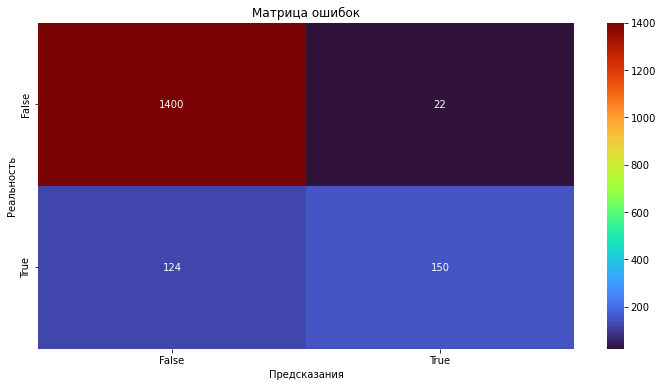

In [62]:
plt.figure(figsize = (12, 6))
fx = sns.heatmap(con_matrix, annot = True, cmap = 'turbo', fmt = 'g')

fx.set_title('Матрица ошибок')
fx.set_xlabel('Предсказания')
fx.set_ylabel('Реальность')

fx.xaxis.set_ticklabels(['False', 'True'])
fx.yaxis.set_ticklabels(['False', 'True'])

Эти данные соответствуют тому, что в 1550 случаях целевой показатель определен верно и только в 146 случаях ошибочно.

#### Анализ важности признаков

Построим диаграмму, показывающую степень важности влияния признаков на конечный результат. В этом нам поможет бибилиотека shap.

In [63]:
explainer = shap.TreeExplainer(lgbm_best_model)
shap_values = explainer.shap_values(features_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


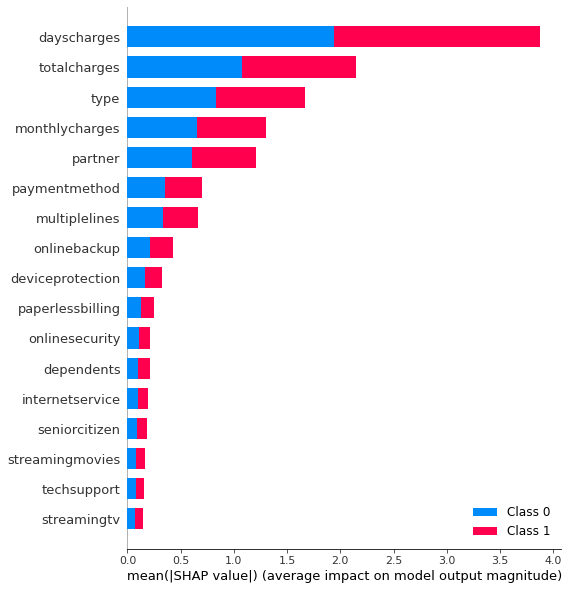

In [64]:
shap.summary_plot(shap_values, features_train)

Как видно из диаграммы, наиболее важным признаком оказался созданный нами `dayscharges`, на втором месте оказался признак `totalcharges`. Эти два признака имеют наибольшую важность. Далее следуют признаки `type`, `monthlycharges` и `partner`.

## Вывод

Подготовлены и проанализированы данные о пакетах услуг клиентов. Подготовлены различные модели обучения, которые прогнозируют отток клиентов компании. Наилучший результат по времени и по показателю ROC-AUC показала модель LGBMRegressor.

А также построена диаграмма анализа важности признаков, которая помогает определить, какие признаки больше всего влияют на конечный результат.